In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, robust_scale, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import des données
DF_app=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/Apprentissage.xlsx',header=0,index_col=0)
DF_app.head()
DF_test=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/Test.xlsx',header=0,index_col=0)
DF_test.head()
DF_val=pd.read_excel('/content/drive/MyDrive/Michelin/Sujet 1/Code/Validation.xlsx',header=0,index_col=0)
DF_val.head()

,Imbibition,Load,FrontRear,channel,speed,accelX,accelY,speedClass,ambiantTemperature,band1,...,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,weatherCheck,textureCheck,TireWear
19754,Imb,2p,rear,1,31.31,-0.0981,0.0981,30,9.43807,-59.787,...,0.55151,-0.267080,0.226340,-0.188940,0.030040,-0.096382,0.013716,Dry,Medium,TavWorn_TarWorn
28897,Nimb,2p,front,1,109.31,0.0981,-0.1962,110,22.13300,-42.977,...,0.14149,0.258950,0.073770,-0.205300,0.071443,0.011874,0.277610,Dry,Smooth,TavWorn_TarWorn
56706,Nimb,2p,front,2,49.43,0.0981,-0.0981,50,22.67030,-51.776,...,0.32270,0.089767,0.024658,-0.074752,-0.107920,-0.034158,-0.168990,Dry,Medium,TavWorn_TarWorn
21433,Imb,2p,rear,1,31.31,-0.0981,0.2943,30,10.74200,-55.228,...,0.53835,-0.245450,0.131800,0.026776,0.230030,0.064923,-0.000991,Dry,Rough,TavMidWorn_TarMidWorn
42675,Imb,2p,front,2,89.50,0.0000,0.0981,90,5.94259,-37.036,...,0.86280,0.494180,0.128730,-0.312620,-0.362270,-0.094860,-0.043071,Dry,Smooth,TavNew_TarNew


In [ ]:
def modif(donnees):
    #on supprime les variables à supprimer
    varSupp=['Load', 'speed']
    for i in varSupp:
        del donnees[i]
    #'accelX'
    donnees["accelX2"]=pd.Series(index=range(donnees.shape[0]),dtype='str')
    donnees.loc[donnees["accelX"]<=(-0.049),"accelX2"]="-0.4905-(-0.049)"
    donnees.loc[(donnees["accelX"]>(-0.049)) & (donnees["accelX"]<=0.049),"accelX2"]="<0.049 - 0.049"
    donnees.loc[donnees["accelX"]>0.049,"accelX2"]=">0.049"

    #'accelY'
    donnees["accelY2"]=pd.Series(index=range(donnees.shape[0]),dtype='str')
    donnees.loc[donnees["accelY"]<=(-0.147),"accelY2"]="<=-0.147"
    donnees.loc[(donnees["accelY"]>(-0.147)) & (donnees["accelY"]<=(-0.049)),"accelY2"]="-0.147 - -0.049"
    donnees.loc[(donnees["accelY"]>(-0.049)) & (donnees["accelY"]<=0.147),"accelY2"]="-0.049 - 0.147"
    donnees.loc[donnees["accelY"]>0.147,"accelY2"]=">0.147"

    #'ambiantTemperature'
    donnees["ambiantTemperature2"]=pd.Series(index=range(donnees.shape[0]),dtype='str')
    donnees.loc[donnees["ambiantTemperature"]<=1.616,"ambiantTemperature2"]="0-1.616"
    donnees.loc[(donnees["ambiantTemperature"]>1.616) & (donnees["ambiantTemperature"]<=7.05),"ambiantTemperature2"]="1.616 - 7.05"
    donnees.loc[(donnees["ambiantTemperature"]>7.05) & (donnees["ambiantTemperature"]<=11.55),"ambiantTemperature2"]="7.05 - 11.55"
    donnees.loc[donnees["ambiantTemperature"]>11.55,"ambiantTemperature2"]=">11.55"

    #on supprimer les colonnes qu on à modifiés
    varMod=['accelX', 'accelY', 'ambiantTemperature']
    for i in varMod:
        del donnees[i]
    #on transforme les variables garder en str
    varGard=['Imbibition', 'FrontRear', 'channel', 'speedClass']
    for i in varGard:
        donnees[i]=donnees[i].astype("str")

    Liste_y = ['weatherCheck', 'textureCheck', 'TireWear']
    for var in Liste_y:
        var_pred = donnees.pop(var)
        donnees.insert(donnees.shape[1], var, var_pred)
    return donnees

In [ ]:
DF_A = DF_app.copy()
DF_T = DF_test.copy()
DF_V = DF_val.copy()

In [ ]:
DF_A = modif(DF_A)
DF_T = modif(DF_T)
DF_V = modif(DF_V)

In [ ]:
lstQuali = [var for var in DF_A.columns[:-3] if DF_A[var].dtype == np.object_]

In [ ]:
dfQualiEncoded = pd.get_dummies(DF_A[lstQuali])
for var in lstQuali :
    del DF_A[var]
DF_A= pd.concat([dfQualiEncoded, DF_A],axis=1)

In [ ]:
dfQualiEncoded = pd.get_dummies(DF_T[lstQuali])
for var in lstQuali :
    del DF_T[var]
DF_T= pd.concat([dfQualiEncoded,DF_T],axis=1)

In [ ]:
dfQualiEncoded = pd.get_dummies(DF_V[lstQuali])
for var in lstQuali :
    del DF_V[var]
DF_V= pd.concat([dfQualiEncoded,DF_V],axis=1)

In [ ]:
DF_A.columns

Index(['Imbibition_Imb', 'Imbibition_Nimb', 'Imbibition_Uimb',
       'FrontRear_front', 'FrontRear_rear', 'channel_1', 'channel_2',
       'speedClass_110', 'speedClass_30', 'speedClass_50',
       ...
       'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
       'weatherCheck', 'textureCheck', 'TireWear'],
      dtype='object', length=150)

In [ ]:
DF_T.columns

Index(['Imbibition_Imb', 'Imbibition_Nimb', 'Imbibition_Uimb',
       'FrontRear_front', 'FrontRear_rear', 'channel_1', 'channel_2',
       'speedClass_110', 'speedClass_30', 'speedClass_50',
       ...
       'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
       'weatherCheck', 'textureCheck', 'TireWear'],
      dtype='object', length=150)

In [ ]:
DF_V.columns

Index(['Imbibition_Imb', 'Imbibition_Nimb', 'Imbibition_Uimb',
       'FrontRear_front', 'FrontRear_rear', 'channel_1', 'channel_2',
       'speedClass_110', 'speedClass_30', 'speedClass_50',
       ...
       'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
       'weatherCheck', 'textureCheck', 'TireWear'],
      dtype='object', length=150)

In [ ]:
X_app = DF_A[DF_A.columns[:-3]]
Y_app = DF_A[DF_A.columns[-3:]]
X_test = DF_T[DF_T.columns[:-3]]
Y_test = DF_T[DF_T.columns[-3:]]
print(Y_test.columns)

Index(['weatherCheck', 'textureCheck', 'TireWear'], dtype='object')


depth= 25 leaf= 10
0.9747566123890755
0.9688980787455845
0.9477901266477126


depth= 25 leaf= 25
0.9779443439303869
0.9546825191694667
0.940294649780305


depth= 25 leaf= 50
0.9806151460325666
0.9417592831911777
0.9228913586628759


depth= 50 leaf= 10
0.975532006547773
0.9689842336521065
0.9471008873955372


depth= 50 leaf= 25
0.977772034117343
0.9545963642629448
0.9398638752476953


depth= 50 leaf= 50
0.9806151460325666
0.9419315930042216
0.922719048849832




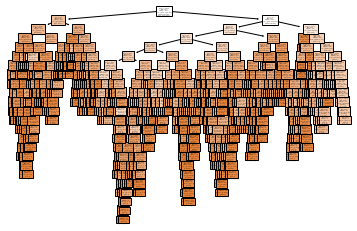

In [ ]:
depth=[25,50]
leaf=[10,25,50]
for dep in depth:
    for lea in leaf:
        arbre1=DecisionTreeClassifier(max_depth=dep,min_samples_leaf=lea)
        arbre1.fit(X_app,Y_app)
        plot_tree(arbre1, filled=True)
        #plt.show()
        print("depth=",dep,"leaf=",lea)
        predfirst=arbre1.predict(X=X_test)
        #print(predfirst[:5,:])
        #print(Y_test.head(5))
        #print(confusion_matrix(Y_test['weatherCheck'], predfirst[:,0]))
        print(metrics.accuracy_score(Y_test['weatherCheck'],predfirst[:,0]))
        #print(confusion_matrix(Y_test['textureCheck'], predfirst[:,1]))
        print(metrics.accuracy_score(Y_test['textureCheck'],predfirst[:,1]))
        #print(confusion_matrix(Y_test['TireWear'], predfirst[:,2]))
        print(metrics.accuracy_score(Y_test['TireWear'],predfirst[:,2]))
        print("\n")

In [ ]:
predvalid=arbre1.predict(X=X_valid)
print(metrics.accuracy_score(Y_valid['weatherCheck'],predvalid[:,0]))
        #print(confusion_matrix(Y_test['textureCheck'], predfirst[:,1]))
print(metrics.accuracy_score(Y_valid['textureCheck'],predvalid[:,1]))
        #print(confusion_matrix(Y_test['TireWear'], predfirst[:,2]))
print(metrics.accuracy_score(Y_valid['TireWear'],predvalid[:,2]))

NameError: ignored